In [1]:
%pylab inline
import matplotlib.pyplot as plt



Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
from scipy.stats import ttest_rel
import copy
import pickle
import pandas as pd
import copy

from sklearn.preprocessing import MinMaxScaler


import numpy as np
from numpy import linalg as LA
import scipy
from sklearn import preprocessing

from gensim.models import Word2Vec
from gensim import utils
from gensim.corpora import Dictionary

from scipy.stats.stats import spearmanr
from scipy.stats.stats import pearsonr


from sklearn.decomposition import PCA

In [3]:
we_model_name = "sg_dim300_min200_win5"
we_vector_size = 300

we_model_dir = "/share/home/navid/wordembeddings/word2vecgensim/wikipedia/wiki-english-20171001/%s" % we_model_name



In [4]:
we_model = Word2Vec.load(we_model_dir+'/model.gensim')

print ('loading done!')

loading done!


In [5]:
len(we_model.wv.vocab)

197549

### Loading words

In [6]:
genderword_tuples = []

with open('resources/wordlist_genderspecific.txt') as fr:
    for l in fr:
        _tuple=l.strip('\n').split(',')
        if _tuple[0] in we_model.wv.vocab:
            _idx = we_model.wv.vocab[_tuple[0]].index
            genderword_tuples.append((_tuple[0], _tuple[1], _idx))
        else:
            print (_tuple[0])
print (len([x for x in genderword_tuples if x[1]=='f']))
print (len([x for x in genderword_tuples if x[1]=='m']))



28
28


In [18]:
labels = {}
labels['set1'] = 'Math'
labels['set2'] = 'Arts'
labels['set3'] = 'Science'

terms = {}
terms['set1'] = ['math','algebra','geometry','calculus', 'equations','computation','numbers','addition']
terms['set2'] = ['poetry','art','dance','literature', 'novel','symphony','drama','sculpture']
terms['set3'] = ['science','technology','physics','chemistry', 'Einstein','NASA','experiment','astronomy']

[terms['set1'], terms['set2'], terms['set3']] = [[str.lower(term) for term in _terms] for _terms in [terms['set1'], terms['set2'], terms['set3']]]


## calculating bias

In [24]:

def get_1st_association(target_word, attribute_words):
    ctx_vecs = []
    for _word in attribute_words:
        _idx = we_model.wv.vocab[_word].index
        ctx_vecs.append(we_model.trainables.syn1neg[_idx])
    ctx_vecs = np.array(ctx_vecs)    
    
    _vec = we_model.wv[target_word]
    associations = scipy.special.expit(np.dot(ctx_vecs, _vec))
    association_mean = np.mean(associations)
    
    return association_mean

def get_1st_associations_allwords(attribute_words):
    ctx_vecs = []
    for _word in attribute_words:
        _idx = we_model.wv.vocab[_word].index
        ctx_vecs.append(we_model.trainables.syn1neg[_idx])
    ctx_vecs = np.array(ctx_vecs)    
    
    _vecs = we_model.wv.vectors
    associations = scipy.special.expit(np.dot(_vecs, ctx_vecs.T))
    associations_mean = np.mean(associations, axis=1)
    
    return associations_mean


def get_1st_bias(target_terms, A_terms, B_terms):
    
    allwords_A_associations = get_1st_associations_allwords(A_terms)
    allwords_B_associations = get_1st_associations_allwords(B_terms)
    
    all_associations = np.concatenate((allwords_A_associations, allwords_B_associations))
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(all_associations.reshape(-1, 1)) 
    
    biases = {}
    for word in target_terms:
        _A_assoc = get_1st_association(word, A_terms)
        _B_assoc = get_1st_association(word, B_terms)
        _A_assoc = scaler.transform(_A_assoc.reshape(-1, 1))[0,0]
        _B_assoc = scaler.transform(_B_assoc.reshape(-1, 1))[0,0]
        biases[word] = _A_assoc - _B_assoc
    
    _th = np.mean(np.abs(allwords_A_associations - allwords_B_associations))
    _th = scaler.transform(_th.reshape(-1, 1))[0,0]
        
    return biases, _th
    
results_1st = {}
_set1_metrics, _th = get_1st_bias(set1_terms, [x[0] for x in genderword_tuples if x[1]=='f'], [x[0] for x in genderword_tuples if x[1]=='m'])
_set2_metrics, _th = get_1st_bias(set2_terms, [x[0] for x in genderword_tuples if x[1]=='f'], [x[0] for x in genderword_tuples if x[1]=='m'])
_set3_metrics, _th = get_1st_bias(set3_terms, [x[0] for x in genderword_tuples if x[1]=='f'], [x[0] for x in genderword_tuples if x[1]=='m'])


results_1st = {'mean':{}, 'biases':{}}
results_1st['mean']['set1'] = np.mean(list(_set1_metrics.values()))
results_1st['biases']['set1'] = _set1_metrics
results_1st['mean']['set2'] = np.mean(list(_set2_metrics.values()))
results_1st['biases']['set2'] = _set2_metrics
results_1st['mean']['set3'] = np.mean(list(_set3_metrics.values()))
results_1st['biases']['set3'] = _set3_metrics


results_1st['threshold'] = _th
print (results_1st)

{'mean': {'set1': 0.01854644, 'set2': 0.07771382, 'set3': 0.022503411}, 'biases': {'set1': {'math': 0.07286592, 'algebra': 0.005301168, 'geometry': 0.0019129589, 'calculus': -0.007939991, 'equations': 0.007935947, 'computation': 0.0070613967, 'numbers': 0.017723419, 'addition': 0.043510698}, 'set2': {'poetry': 0.08626373, 'art': 0.06420762, 'dance': 0.14825647, 'literature': 0.066634625, 'novel': 0.10813326, 'symphony': 0.012089878, 'drama': 0.08790605, 'sculpture': 0.04821893}, 'set3': {'science': 0.032286882, 'technology': 0.013874892, 'physics': -0.0024275184, 'chemistry': 0.02002038, 'einstein': 0.019499868, 'nasa': 0.030015156, 'experiment': 0.050463997, 'astronomy': 0.016293637}}, 'threshold': 0.047690045}


In [25]:

def get_2nd_association(target_word, attribute_words):
    target_vec = we_model.wv[target_word]
    attribute_vecs = np.array([we_model.wv[_w] for _w in attribute_words])
    
    _dot_v = np.dot(attribute_vecs, target_vec)
    _norms = np.multiply(np.linalg.norm(attribute_vecs, axis=1), np.linalg.norm(target_vec))
    _associations = np.divide(_dot_v, _norms)
    _association_mean = np.mean(_associations)
    
    return _association_mean

def get_2nd_mean_allwords(attribute_words):
    vecs = np.array([we_model.wv[_w] for _w in attribute_words])
    
    vecs_normalized = vecs/np.linalg.norm(vecs, axis=1).reshape(-1,1)
    vecs_normalized_allwords = we_model.wv.vectors/np.linalg.norm(we_model.wv.vectors, axis=1).reshape(-1,1)
    
    associations_allwords = np.dot(vecs_normalized, vecs_normalized_allwords.T)
    associations_mean_allwords = np.mean(associations_allwords, axis=0)
    
    return associations_mean_allwords

def get_2nd_bias(target_terms, A_terms, B_terms):
    allwords_A_associations = get_2nd_mean_allwords(A_terms)
    allwords_B_associations = get_2nd_mean_allwords(B_terms)
    
    all_associations = np.concatenate((allwords_A_associations, allwords_B_associations))
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(all_associations.reshape(-1, 1)) 
    
    _th = np.mean(np.abs(allwords_A_associations - allwords_B_associations))
    _th = scaler.transform(_th.reshape(-1, 1))[0,0]
        
    biases = {}
    for word in target_terms:
        _A_assoc = get_2nd_association(word, A_terms)
        _B_assoc = get_2nd_association(word, B_terms)
        _A_assoc = scaler.transform(_A_assoc.reshape(-1, 1))[0,0]
        _B_assoc = scaler.transform(_B_assoc.reshape(-1, 1))[0,0]
        biases[word] = _A_assoc - _B_assoc

    return biases, _th

results_2nd = {}
_set1_metrics, _th = get_2nd_bias(set1_terms, [x[0] for x in genderword_tuples if x[1]=='f'], [x[0] for x in genderword_tuples if x[1]=='m'])
_set2_metrics, _th = get_2nd_bias(set2_terms, [x[0] for x in genderword_tuples if x[1]=='f'], [x[0] for x in genderword_tuples if x[1]=='m'])
_set3_metrics, _th = get_2nd_bias(set3_terms, [x[0] for x in genderword_tuples if x[1]=='f'], [x[0] for x in genderword_tuples if x[1]=='m'])


results_2nd = {'mean':{}, 'biases':{}}
results_2nd['mean']['set1'] = np.mean(list(_set1_metrics.values()))
results_2nd['biases']['set1'] = _set1_metrics
results_2nd['mean']['set2'] = np.mean(list(_set2_metrics.values()))
results_2nd['biases']['set2'] = _set2_metrics
results_2nd['mean']['set3'] = np.mean(list(_set3_metrics.values()))
results_2nd['biases']['set3'] = _set3_metrics



results_2nd['threshold'] = _th
print (results_2nd)


{'mean': {'set1': -0.0061573526, 'set2': 0.043226358, 'set3': 0.0016450491}, 'biases': {'set1': {'math': 0.042874858, 'algebra': -0.01902835, 'geometry': -0.0206801, 'calculus': -0.035577446, 'equations': -0.0061583817, 'computation': 0.020831846, 'numbers': -0.026295915, 'addition': -0.0052253306}, 'set2': {'poetry': 0.052357107, 'art': 0.05332002, 'dance': 0.07742286, 'literature': 0.059557647, 'novel': 0.055918783, 'symphony': 0.0012508035, 'drama': 0.03886184, 'sculpture': 0.0071218014}, 'set3': {'science': 0.020898655, 'technology': 0.008845732, 'physics': -0.03624001, 'chemistry': -0.0104650855, 'einstein': -0.0023926198, 'nasa': 0.01606372, 'experiment': 0.021849036, 'astronomy': -0.0053990334}}, 'threshold': 0.036875594}


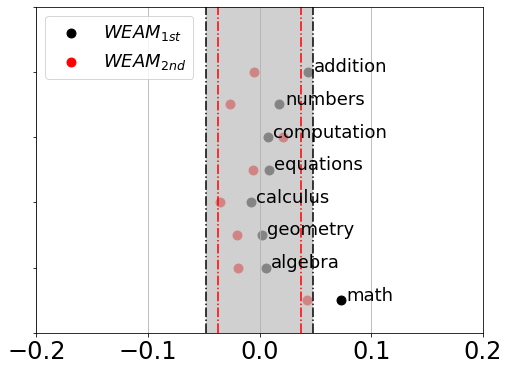

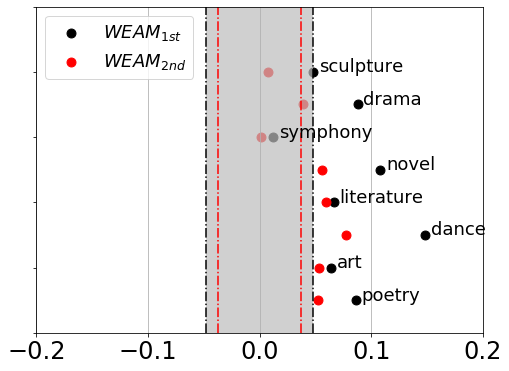

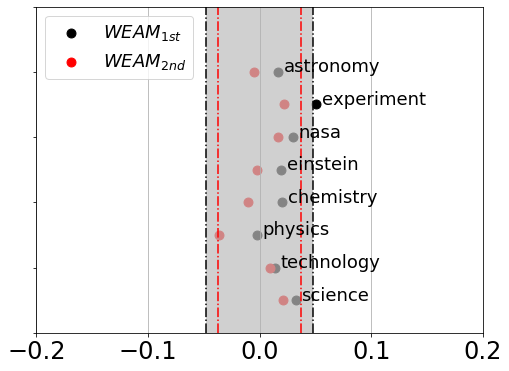

In [62]:

_color_unbiasedarea='#bdbdbd'
_color_unbiasedarea2='red'
_color_unbiasedborder='black'#'#737373'
_color_unbiasedborder2='red'
_color_unbiasedpnt='#636363'
_color_SG_male='red'
_color_eSG_male='black'
_color_SG_female='#6baed6'#3182bd
_color_eSG_female='#08519c'


ZERO_LINE_COLOR = 'lime'
FIRST_ORDER_COLOR = 'black'
SECOND_ORDER_COLOR = 'red'
SHADE_DARKNESS = 0.2
XAXIS_LIMIT = 0.2
TITLE_FONT_SIZE = 12    
LEGEND_SIZE = 14
fsize = 24
fsize2 = 18
_psize = 80 # Marker size



threshold_1st = results_1st['threshold']
threshold_2nd = results_2nd['threshold']


for set_name in ['set1', 'set2', 'set3']:
    fig, ax = plt.subplots(1,1, figsize=(8,6))

    allterms = []
    target_labels = []
    biases_1st = []
    biases_2nd = []
    y_vals = []
    X_terms_count = 0

    _terms = terms[set_name]
    _label = labels[set_name]

    biases_1st.extend([results_1st['biases'][set_name][x] for x in _terms])
    mean_1st = results_1st['mean'][set_name]

    biases_2nd.extend([results_2nd['biases'][set_name][x] for x in _terms])
    mean_2nd = results_2nd['mean'][set_name]

    y_vals = [i for i in range(1, len(biases_1st) + 1)]
    X_terms_count = len(y_vals)

    #ax.text(-XAXIS_LIMIT+0.02, y_vals[-1]-1, target_label, size=fsize, bbox=dict(boxstyle="square", fc="w", ec="k"))

    ax.scatter(biases_1st, y_vals, marker='o', c=FIRST_ORDER_COLOR, s=_psize, label=r'$WEAM_{1st}$')
    ax.scatter(biases_2nd, y_vals, marker='o', c=SECOND_ORDER_COLOR, s=_psize, label=r'$WEAM_{2nd}$')

    ax.axvline(threshold_1st, c=FIRST_ORDER_COLOR, linestyle='-.')
    ax.axvline(threshold_2nd, color=SECOND_ORDER_COLOR, linestyle='-.')
    ax.axvline(-threshold_1st, c=FIRST_ORDER_COLOR, linestyle='-.')
    ax.axvline(-threshold_2nd, color=SECOND_ORDER_COLOR, linestyle='-.')

    ax.set_xlim(-XAXIS_LIMIT, XAXIS_LIMIT)

    for i, txt in enumerate(_terms):
        ax.annotate(txt, (biases_1st[i]+0.005, y_vals[i]+0.005), fontsize=fsize2)

    #ax.set_xlabel('Inclination (bias): %s (-) vs. %s (+)' % (B_label, A_label), fontsize=fsize)
    ax.yaxis.set_ticklabels([])

    max_y = max(y_vals) + 2
    ax.fill_between([-max(threshold_1st,threshold_2nd),max(threshold_1st,threshold_2nd)],
                    [0, 0], [max_y, max_y], facecolor=_color_unbiasedarea, alpha=0.7, interpolate=True)


    ax.set_ylim(0, max_y)


    ax.xaxis.grid()
    ax.legend(loc=2, prop={'size': fsize2})
    ax.tick_params(which='major', labelsize=fsize)

    plt.show()
    fig.tight_layout()
    fig.set_size_inches(8, 6)
    fig.savefig('plots/gender_bias_%s.pdf' % (labels[set_name]), dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)




In [37]:
_lst

[('technology', -0.0050291605),
 ('science', -0.011388227),
 ('nasa', -0.013951436)]

## Analysis of Bias

In [45]:
#the most important context words contributing to bias using 2nd_mean on rec vectors

_lst = []
for set_name in ['set1', 'set2', 'set3']:
    _lst += [(w, results_1st['biases'][set_name][w] - results_2nd['biases'][set_name][w]) for w in results_2nd['biases'][set_name]]

_lst.sort (key=lambda x: x[1], reverse=True)
_lst = _lst[:5]
print (_lst)

for _tuple in _lst:
    _target_word = _tuple[0]

    _target_vec = scipy.special.expit(np.dot(we_model.wv[_target_word], we_model.trainables.syn1neg.T))

    _A_recSG_mean = np.zeros(len(_target_vec))
    _A_terms = [x[0] for x in genderword_tuples if x[1]=='f']
    for _att_word in _A_terms:
        _rec_vec = scipy.special.expit(np.dot(we_model.wv[_att_word], we_model.trainables.syn1neg.T))
        _A_recSG_mean += (_target_vec/LA.norm(_target_vec)) * (_rec_vec/LA.norm(_rec_vec))
    _A_recSG_mean /= len(_A_terms)

    _B_recSG_mean = np.zeros(len(_target_vec))
    _B_terms = [x[0] for x in genderword_tuples if x[1]=='m']
    for _att_word in _B_terms:
        _rec_vec = scipy.special.expit(np.dot(we_model.wv[_att_word], we_model.trainables.syn1neg.T))
        _B_recSG_mean += (_target_vec/LA.norm(_target_vec)) * (_rec_vec/LA.norm(_rec_vec))
    _B_recSG_mean /= len(_B_terms)

    _bias_recSG_mean = _A_recSG_mean - _B_recSG_mean

    _mult = list(zip((_bias_recSG_mean), we_model.wv.index2word))

    _mult.sort(key=lambda x:x[0], reverse=True)
    print (_target_word)
    print ('Towards female:', [x[1] for x in _mult][:5])
    print ('Towards   male:', [x[1] for x in _mult][::-1][:5])
    _mult.sort(key=lambda x:abs(x[0]), reverse=True)
    print ('Both          :', [x[1] for x in _mult][:5])
    print ()





[('dance', 0.07083361), ('novel', 0.052214473), ('drama', 0.049044207), ('addition', 0.04873603), ('numbers', 0.044019334)]
dance
Towards female: ['ballerina', 'dancer', 'danced', 'ballet', 'ballerinas']
Towards   male: ['djing', 'sandaime', 'shambhu', 'uday', 'tutelage']
Both          : ['ballerina', 'dancer', 'danced', 'ballet', 'ballerinas']

novel
Towards female: ['feminist', 'heroine', 'angelou', 'lesbian', 'fredrika']
Towards   male: ['cormac', 'fyodor', 'dostoyevsky', 'thackeray', 'crichton']
Both          : ['feminist', 'heroine', 'angelou', 'lesbian', 'fredrika']

drama
Towards female: ['actress', 'actresses', 'hye', 'telenovela', 'heroine']
Towards   male: ['nadiadwala', 'vijay', 'salmaan', 'ivane', 'debutant']
Both          : ['actress', 'actresses', 'hye', 'telenovela', 'heroine']

addition
Towards female: ['feminist', 'nurses', 'suffrage', 'nursing', 'maternity']
Towards   male: ['iwrg', 'builder', 'enlisted', 'cmll', 'estates']
Both          : ['feminist', 'nurses', 'suff